# <center>Data Mining Project Code</center>

** **
## <center>*Spending Data Segmentation*</center>

** **

In this notebook, we will implement different clustering methods in order to analyse and group customers by spending-related features.

** **
The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# ToC

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

2. [Clustering](#2.-Clustering) <br>

    2.1 [Hierarchical Clustering](#2.1-Hierarchical-Clustering) <br><br>
    2.2 [K-Means](#2.2-K-Means) <br><br>
    2.3 [Self-Organizing Maps (SOM)](#2.3-Self-Organizing-Maps-(SOM)) <br><br>
    2.4 [Density-based Clustering](#2.4-Density-based-Clustering) <br><br>
    
    &emsp; 2.4.1 [Meanshift](#2.4.1-Meanshift)<br><br>
    &emsp; 2.4.2 [DBScan](#2.4.2-Density-Based-Spatial-Clustering-of-Applications-with-Noise-(DBSCAN))<br><br>
    &emsp; 2.4.3 [HDBScan](#2.4.3-HDBScan)<br><br>
    
    
    
    
 

# 1. Importing Libraries & Data

In [16]:
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import cm

# Scalers
from sklearn.preprocessing import RobustScaler, StandardScaler, \
                                  MinMaxScaler

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from minisom import MiniSom
import umap.umap_ as umap

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt
import functions as f

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

path = './plots/spending_data/'

In [17]:
categorical_columns = [
    'payment_method', 'promo_DELIVERY', 'promo_DISCOUNT', 'promo_FREEBIE',
    'pay_CARD', 'pay_CASH', 'payment_method_enc', 'last_promo_enc'
]

data = pd.read_csv('data/data.csv', 
                   index_col = "customer_id")
spending_data = data[s.spending_orders]
spending_data = spending_data.drop(columns=categorical_columns)

In [4]:
spending_data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_orders,30850.0,4.062982,4.037679,1.00,2.000000,3.000000,5.000,43.00
total_spend,30850.0,35.217035,36.037594,0.37,12.790000,23.910000,43.340,328.99
avg_spend_prod,30850.0,7.563675,4.061857,0.00,4.105179,6.926515,10.135,24.39
HR_1,30850.0,0.050859,0.291049,0.00,0.000000,0.000000,0.000,8.00
HR_2,30850.0,0.058023,0.304809,0.00,0.000000,0.000000,0.000,8.00
HR_3,30850.0,0.113679,0.476228,0.00,0.000000,0.000000,0.000,11.00
HR_4,30850.0,0.096564,0.398518,0.00,0.000000,0.000000,0.000,8.00
HR_5,30850.0,0.077796,0.339004,0.00,0.000000,0.000000,0.000,5.00
HR_6,30850.0,0.065413,0.309341,0.00,0.000000,0.000000,0.000,8.00
HR_7,30850.0,0.069465,0.313822,0.00,0.000000,0.000000,0.000,8.00


# 2. Clustering

<a href="#top">Top &#129033;</a>

**Scale Data Before Clustering**

In [18]:
scaled_data = MinMaxScaler().fit_transform(spending_data)

In [19]:
scaled_data = pd.DataFrame(scaled_data, 
                           columns=spending_data.columns, 
                           index=spending_data.index)

## 2.1 Hierarchical Clustering

To develop a clustering solution using hierarchical clustering, the following steps were carried out:

**1. Creating Dendrograms for All Combinations**
- Dendrograms were generated for all combinations of linkage methods (e.g., single, complete, average, ward) and distance metrics (e.g., Euclidean, Manhattan).
- This step provided a visual representation of the clustering hierarchy to understand how clusters merge at different thresholds.
- The dendrograms were analysed to identify configurations that produced distinct and meaningful clusters.

**2. Selecting the Best Combinations**
- Based on the dendrograms, the most promising combinations of linkage methods and distance metrics were shortlisted.
- The selection was based on:
  - Clear separation of clusters (visible gaps in the dendrograms).
  - Avoidance of configurations that produced excessive chaining effects or imbalanced clusters.
- This step narrowed the scope to the most viable configurations.

**3. Evaluating the Shortlisted Combinations**
- The shortlisted configurations were quantitatively evaluated using the following metrics:
  - **R² Score**: Measures how well the clustering structure explains the variance in the data. Higher values indicate a better-defined cluster structure.
  - **Silhouette Score**: Evaluates the compactness and separation of clusters. Scores range from -1 (poor clustering) to 1 (ideal clustering), providing insights into cluster quality.
  - **Calinski-Harabasz Score**: Assesses the ratio of the sum of cluster dispersion to inter-cluster distances. Higher values indicate well-separated and compact clusters.
- By leveraging these metrics, the combination of linkage methods and distance metrics producing the highest-quality clusters was identified and selected.

<a href="#top">Top &#129033;</a>

In [37]:
linkages = ["complete", "average", "single", "ward"]

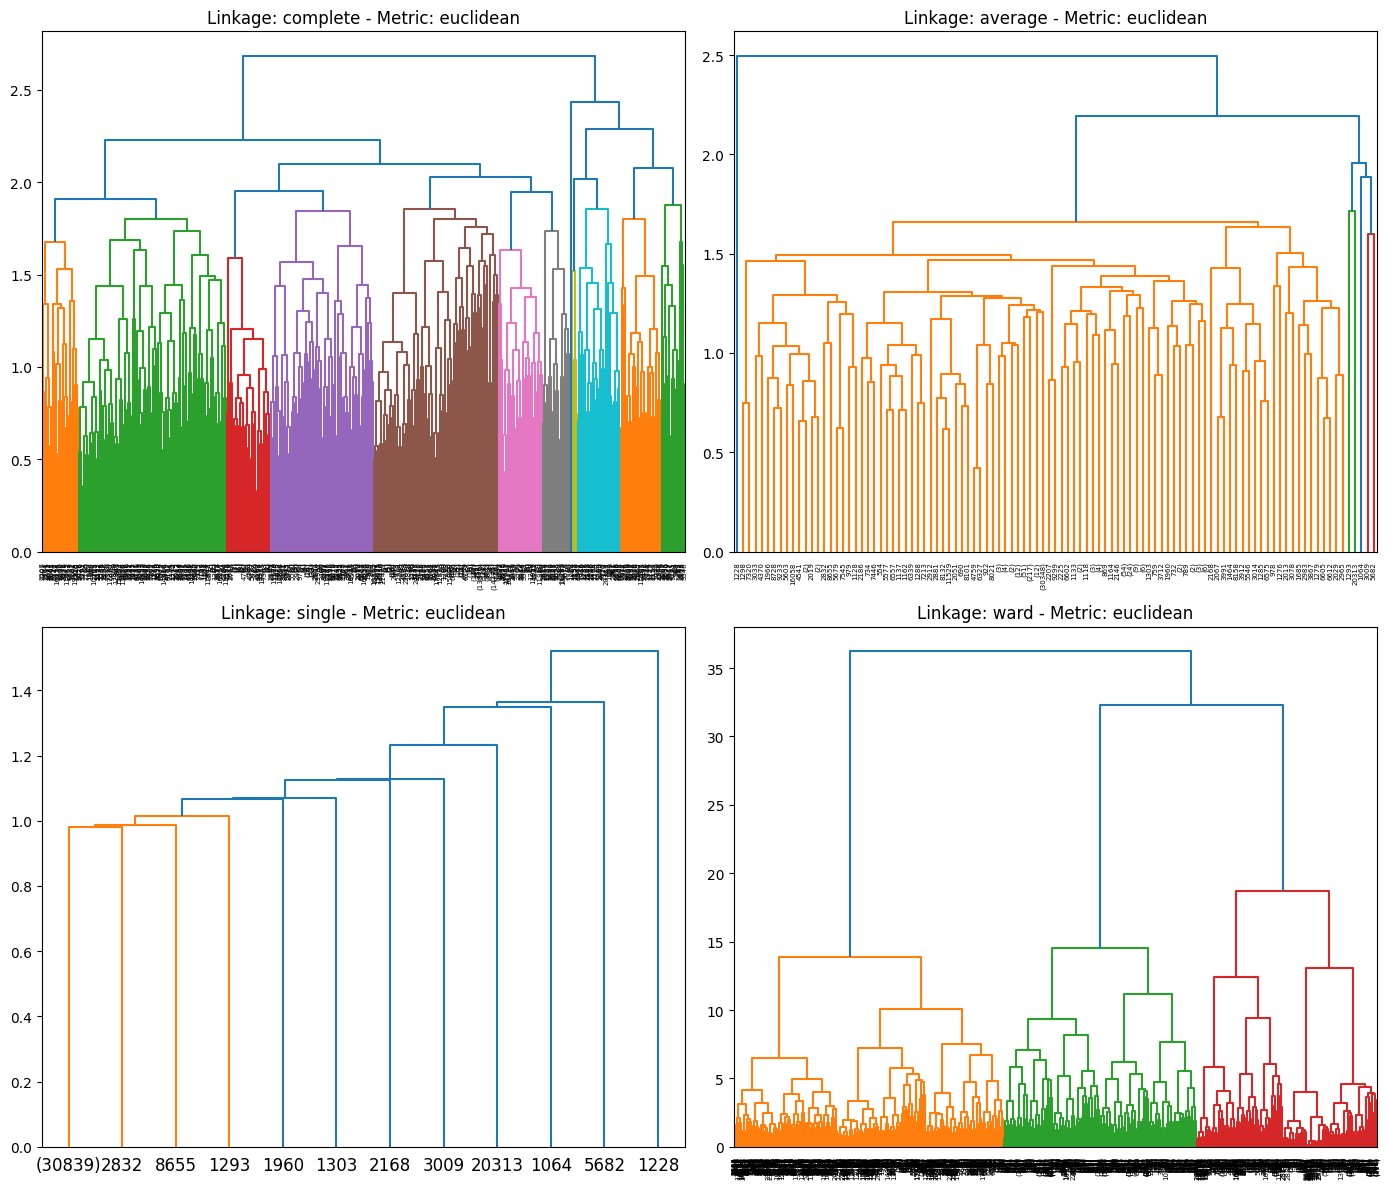

In [38]:
f.plot_hierarchical_dendrograms(scaled_data, 
                                path=path+'euclidean', 
                                linkages=linkages, 
                                metrics=['euclidean'])

In [ ]:
f.plot_hierarchical_dendrograms(scaled_data, 
                                path=path+'others', 
                                linkages=linkages[:3], 
                                metrics=['l1', 'l2', 'manhattan',
                                         'cosine'])

In [10]:
hr_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'ward', "metric": 'euclidean'}
    for k in range(2,7)
] + [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'complete', "metric": 'l2'}
    for k in range(2, 5)
] + [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'complete', "metric": 'l1'}
    for k in range(2, 7)
] + [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'complete', "metric": 'manhattan'}
    for k in range(2, 5)
] 

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data, feats=scaled_data.columns.tolist(), **settings)
    hr_results.append(result)

# Convert results to DataFrame
hr_results_df = pd.DataFrame(hr_results)
hr_results_df

,Model,n_clusters,linkage,metric,R2,Silhouette,Calinski-Harabasz
0,hierarchical,2,ward,euclidean,0.128885,0.438706,4564.086689
1,hierarchical,3,ward,euclidean,0.231338,0.156466,4641.898066
2,hierarchical,4,ward,euclidean,0.265704,0.128339,3720.536606
3,hierarchical,5,ward,euclidean,0.286441,0.065174,3095.498625
4,hierarchical,6,ward,euclidean,0.305402,0.066653,2712.314170
5,hierarchical,2,complete,l2,0.027076,0.680890,858.480491
6,hierarchical,3,complete,l2,0.027740,0.678760,440.057728
7,hierarchical,4,complete,l2,0.029586,0.666094,313.482459
8,hierarchical,2,complete,l1,0.001194,0.789651,36.862853
9,hierarchical,3,complete,l1,0.040220,0.676760,646.323251


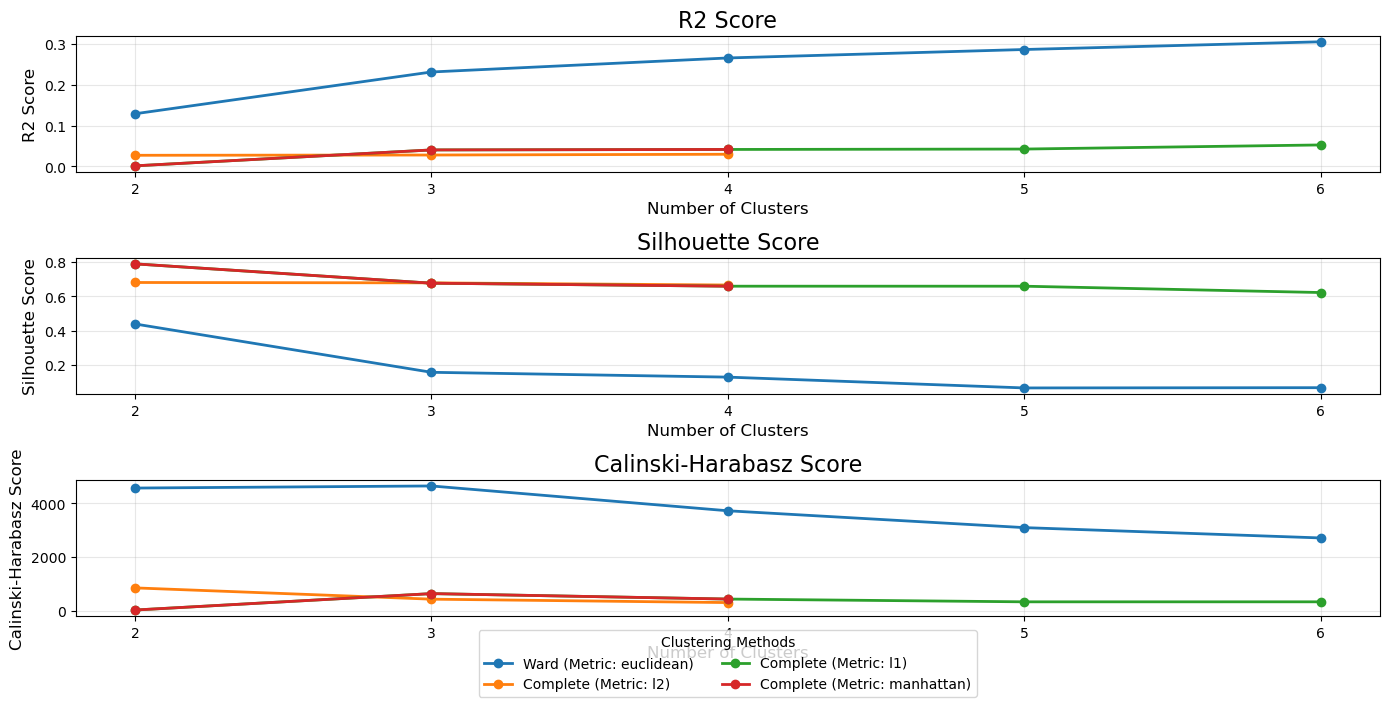

In [19]:
f.plot_evaluation_scores(hr_results_df, path+'hierarch')

**Final Model for Hierarchical Clustering**

In [ ]:
linkage = 'complete'
distance = 'manhattan'
n_clusters = 2

hclust = AgglomerativeClustering(linkage=linkage, 
                                 metric=distance, 
                                 n_clusters=n_clusters)

hc_labels = hclust.fit_predict(scaled_data)

In [ ]:
f.plot_cluster_profiling(spending_data, hc_labels, "Hierarchical")

In [ ]:
f.plot_counts(hc_labels)

In [ ]:
umap_object = umap.UMAP(n_neighbors = 5)

umap_embedding = umap_object.fit_transform(scaled_data)

f.plot_dim_reduction(umap_embedding, targets = hc_labels,
                   technique = 'Hierarchical Clustering visualised with UMAP')

## 2.2 K-Means

<a href="#top">Top &#129033;</a>

To develop an optimal clustering solution using the K-Means algorithm, the following steps were carried out:

1. **Using the Elbow Method to Determine a Range for `n_clusters`**
- We began by using the **Elbow Method** to determine an appropriate range of values for the `n_clusters` hyperparameter.
- By plotting the within-cluster sum of squared distances (inertia) for a range of values of `n_clusters`, we identified the "elbow point," where increasing the number of clusters resulted in diminishing improvements to the inertia.
- This step provided a good initial estimate for the potential number of clusters and helped guide further testing.

2. **Evaluating Different `n_clusters` Values**
- After identifying a range of `n_clusters`, we evaluated different values of `n_clusters` based on various clustering quality metrics:
  - **R² Score**
  - **Silhouette Score**
  - **Calinski-Harabasz Score**
- These metrics allowed us to compare the effectiveness of each value for `n_clusters`, providing quantitative insights into cluster quality.

3. **Selecting the Optimal `n_clusters`**
- After evaluating multiple values for `n_clusters` with the metrics, we selected the value that showed the best balance across all three performance measures.
- This value provided the most meaningful and stable clusters, indicating that the K-Means algorithm was able to separate the data in a way that maximized clustering quality.
  
By focusing primarily on tuning `n_clusters`, we ensured that our clustering solution was optimized and tailored to the specific dataset, ultimately delivering high-quality, interpretable clusters.

**Elbow Method**

The **Elbow Method** is a technique used to determine the optimal number of clusters (`n_clusters`) for K-Means clustering. It involves plotting the within-cluster sum of squared distances (inertia) against different values of `n_clusters`. As the number of clusters increases, the inertia decreases, but at a certain point, the rate of improvement slows down. 

The "elbow" is the point on the plot where the inertia starts to level off, indicating that adding more clusters does not lead to significant improvements in clustering quality. This point suggests the optimal number of clusters to use for the dataset, balancing between overfitting and underfitting the model.


In [14]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    dispersion.append(kmeans.inertia_)

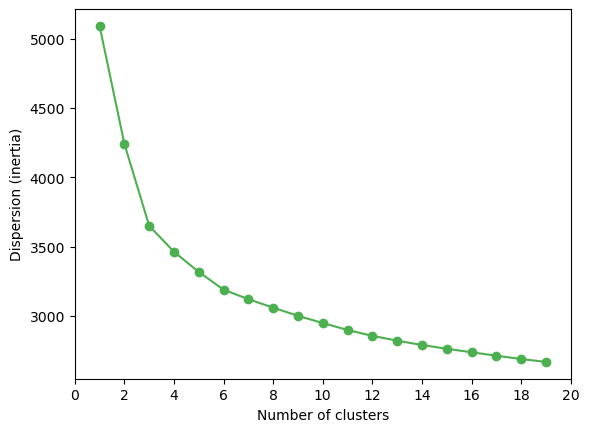

In [15]:
plt.plot(range(1, 20), dispersion, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.xticks(np.arange(0, 21, step=2))  
# plt.vlines(7, 5000, 600000, color='red')

plt.show()

In [16]:
results_kmeans = []

# Define clustering settings
cluster_settings = [
    {"model_type": "kmeans", "n_clusters": k, 'random_state': 42} for k in range(2, 8)
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data, feats=scaled_data.columns.tolist(), **settings)
    results_kmeans.append(result)

# Convert results to DataFrame
results_kmeans_df = pd.DataFrame(results_kmeans)
results_kmeans_df

,Model,n_clusters,random_state,R2,Silhouette,Calinski-Harabasz
0,kmeans,2,42,0.166851,0.418895,6177.783983
1,kmeans,3,42,0.282900,0.175246,6084.655308
2,kmeans,4,42,0.319771,0.170157,4833.508692
3,kmeans,5,42,0.348261,0.165269,4120.555349
4,kmeans,6,42,0.373453,0.098833,3676.910750
5,kmeans,7,42,0.386865,0.113484,3243.467524


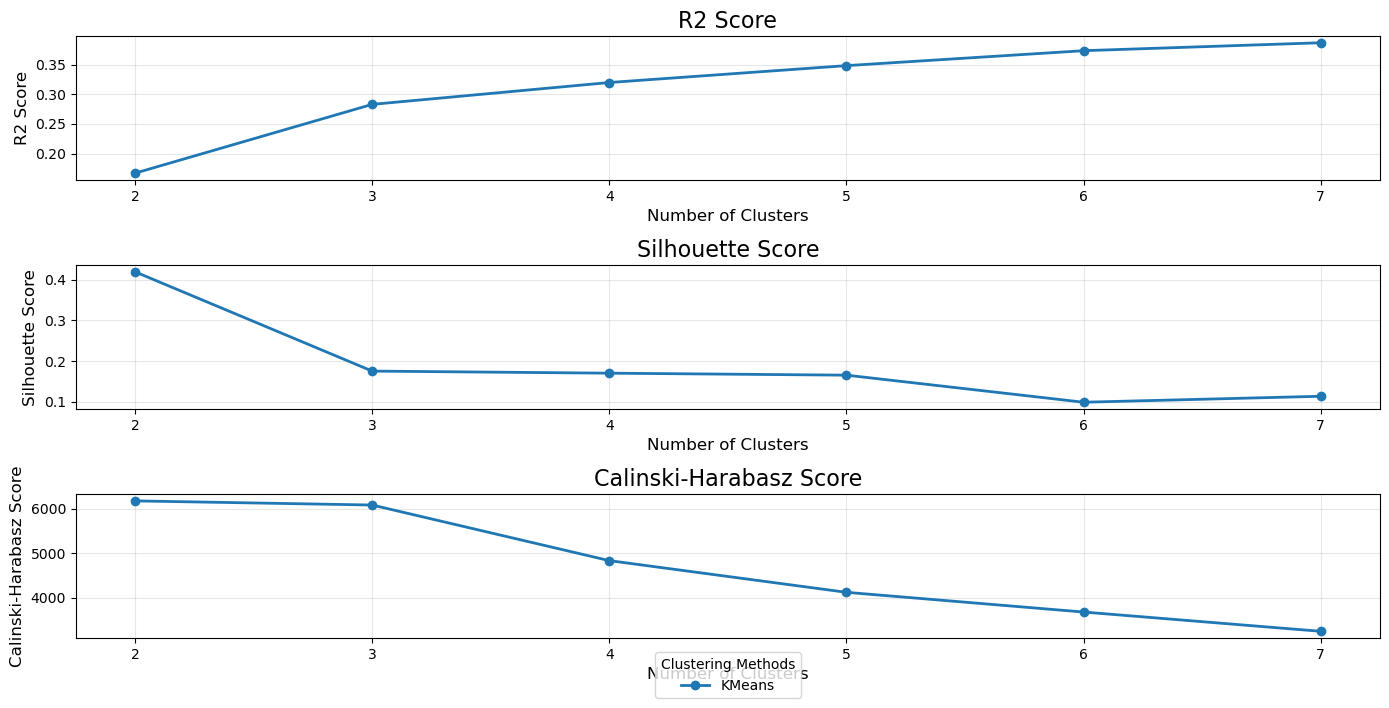

In [20]:
f.plot_evaluation_scores(results_kmeans_df, path+'kmeans')

**Final Solution for K-Means**

In [34]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, 
                 n_init=15, 
                 random_state=1)

km_labels = kmclust.fit_predict(scaled_data)

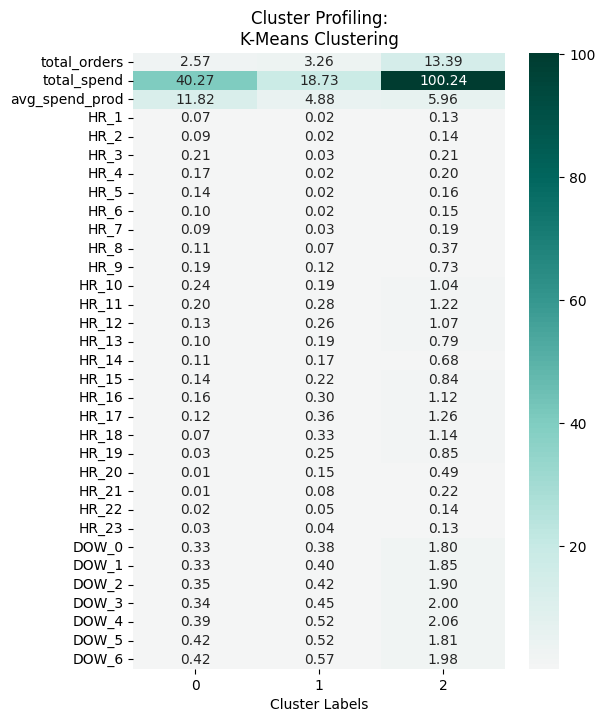

In [15]:
f.plot_cluster_profiling(spending_data, km_labels, "K-Means")

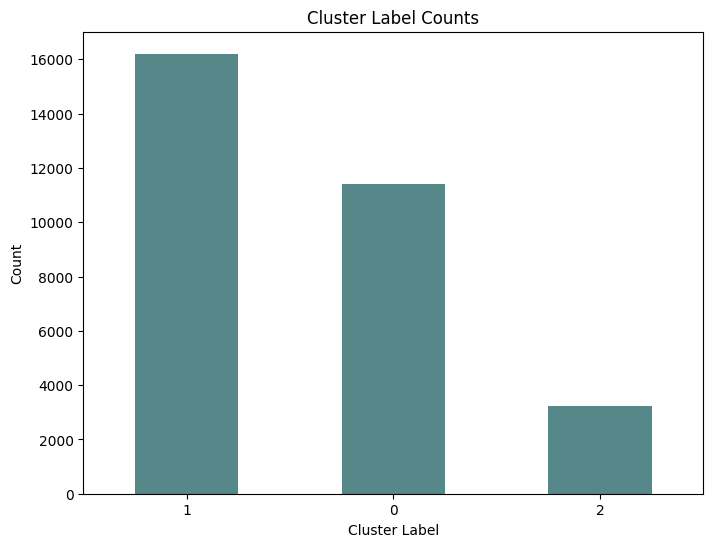

In [16]:
f.plot_counts(km_labels)

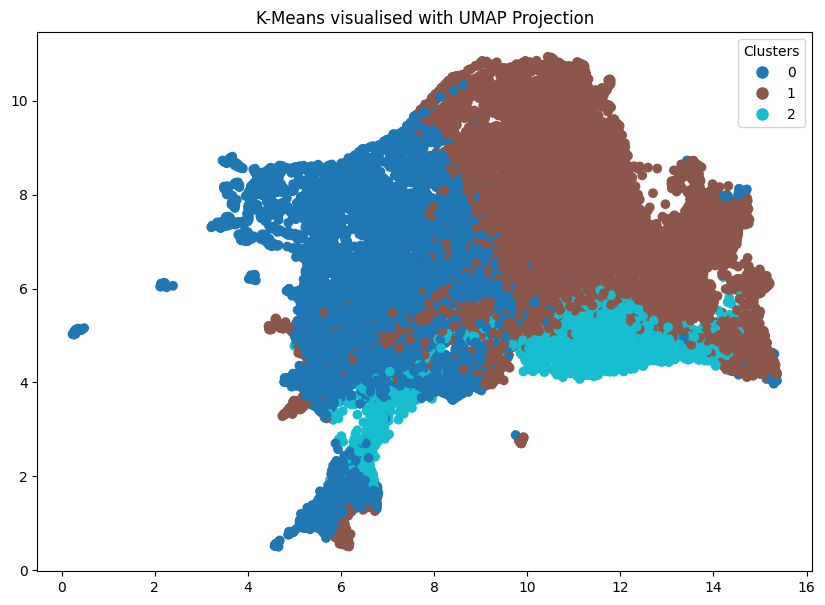

In [17]:
umap_object = umap.UMAP(n_neighbors = 50)
umap_embedding = umap_object.fit_transform(scaled_data)

f.plot_dim_reduction(umap_embedding, targets = km_labels,
                   technique = 'K-Means visualised with UMAP')

## 2.4 Density-based Clustering

<a href="#top">Top &#129033;</a>

### 2.4.1 Meanshift

<a href="#top">Top &#129033;</a>

**Estimate Bandwidth**

In [12]:
bandwidth = estimate_bandwidth(scaled_data)
bandwidth

np.float64(0.4188836048560483)

In [13]:
ms = MeanShift(bandwidth=bandwidth)
mslabels = ms.fit_predict(scaled_data)

KeyboardInterrupt: 

In [ ]:
ms_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "meanshift", 'bandwidth': 0.4188836048560483, 'cluster_all': True, 'min_bin_freq': k}
    for k in range(1, 5)  
] + [
    {"model_type": "meanshift", 'bandwidth': 0.4188836048560483, 'cluster_all': False, 'min_bin_freq': k}
    for k in range(1, 5)  
] 
# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data, feats=scaled_data.columns.tolist(), **settings)
    ms_results.append(result)

# Convert results to DataFrame
ms_results_df = pd.DataFrame(ms_results)
ms_results_df

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)

msclust = ms.fit_predict(scaled_data)

In [ ]:
umap_object = umap.UMAP(n_neighbors = 5)

umap_embedding = umap_object.fit_transform(scaled_data)

ms_labels = kmclust.fit_predict(umap_embedding)

f.plot_dim_reduction(umap_embedding, targets = mslabels,
                   technique = 'K-Means visualised with UMAP')

### 2.4.2 Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

<a href="#top">Top &#129033;</a>

To initialize the DBSCAN clustering algorithm, we first constructed a **K-Distance Graph** to determine an appropriate range for the `eps` hyperparameter. The elbow point in the graph provided a starting point for selecting potential values of `eps`.

With the range of `eps` values suggested by the plot, we tested several combinations of hyperparameters, including:  
- Different values for `eps`.  
- Different algorithm types (`'ball_tree'`, `'kd_tree'`, `'brute'`).  

The combinations were then evaluated using the same metrics previously explained:
- **R² Score**.  
- **Silhouette Score**.  
- **Calinski-Harabasz Score**.

At the end, we choose our best dbscan solution.


**Optimimising *Eps* Parameter**

To determine the optimal value for the `eps` parameter in **DBSCAN**, we started by constructing a **K-Distance Graph**. This approach helps visualize the distances to the k-th nearest neighbour for all points in the dataset and guides us in selecting an appropriate `eps` value. The **`eps` (epsilon)** parameter determines the maximum distance between two points to classify them as part of the same cluster in DBSCAN. 



The **K-Distance Graph** plots the sorted distances to each point’s k-th nearest neighbour. By observing the graph:

1. Look for the **elbow point** in the curve. 
   - This is the region where the distances transition from a gradual increase to a sharp rise. 
   - The elbow indicates the maximum distance within a cluster before reaching outliers.

2. Select an `eps` value slightly larger than the distance at the elbow.
   - This ensures all points within dense clusters are captured without including many outliers.


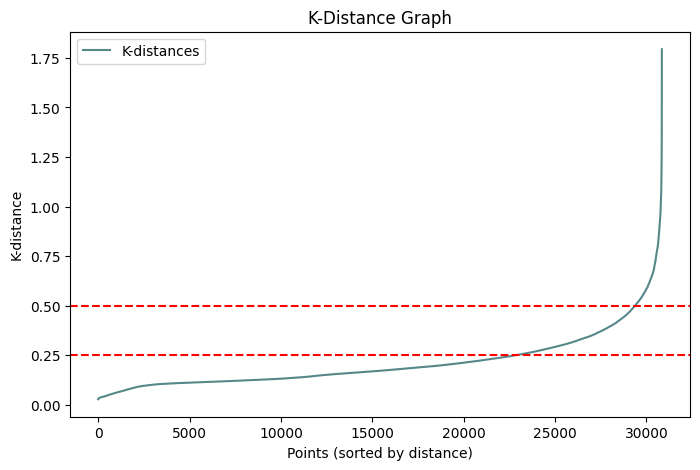

In [7]:
# K-distance graph to find the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(scaled_data)
distances, _ = neigh.kneighbors(scaled_data)
distances = np.sort(distances[:, -1])  

# Plot the distances
plt.figure(figsize=(8, 5))
plt.plot(distances, label="K-distances", color = "#568789")
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axhline(y=0.25, color='red', linestyle='--')
plt.xlabel("Points (sorted by distance)")
plt.ylabel("K-distance")
plt.title("K-Distance Graph")
plt.legend()
plt.show()

In [8]:
db_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "dbscan", "eps": k, "algorithm": 'ball_tree'}
    for k in np.arange(0.25, 0.5, 0.1)  
] + [
    {"model_type": "dbscan", "eps": k, "algorithm": 'kd_tree'}
    for k in np.arange(0.25, 0.5, 0.1)
] + [
    {"model_type": "dbscan", "eps": k, "algorithm": 'brute'}
    for k in np.arange(0.25, 0.5, 0.1)
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data, feats=scaled_data.columns.tolist(), **settings)
    db_results.append(result)

# Convert results to DataFrame
db_results_df = pd.DataFrame(db_results)
db_results_df

,Model,eps,algorithm,R2,Silhouette,Calinski-Harabasz
0,dbscan,0.25,ball_tree,0.155179,0.382466,5666.231807
1,dbscan,0.35,ball_tree,0.146366,0.497216,5289.247430
2,dbscan,0.45,ball_tree,0.114536,0.570765,3990.232087
3,dbscan,0.25,kd_tree,0.155179,0.382466,5666.231807
4,dbscan,0.35,kd_tree,0.146366,0.497216,5289.247430
5,dbscan,0.45,kd_tree,0.114536,0.570765,3990.232087
6,dbscan,0.25,brute,0.155179,0.382466,5666.231807
7,dbscan,0.35,brute,0.146366,0.497216,5289.247430
8,dbscan,0.45,brute,0.114536,0.570765,3990.232087


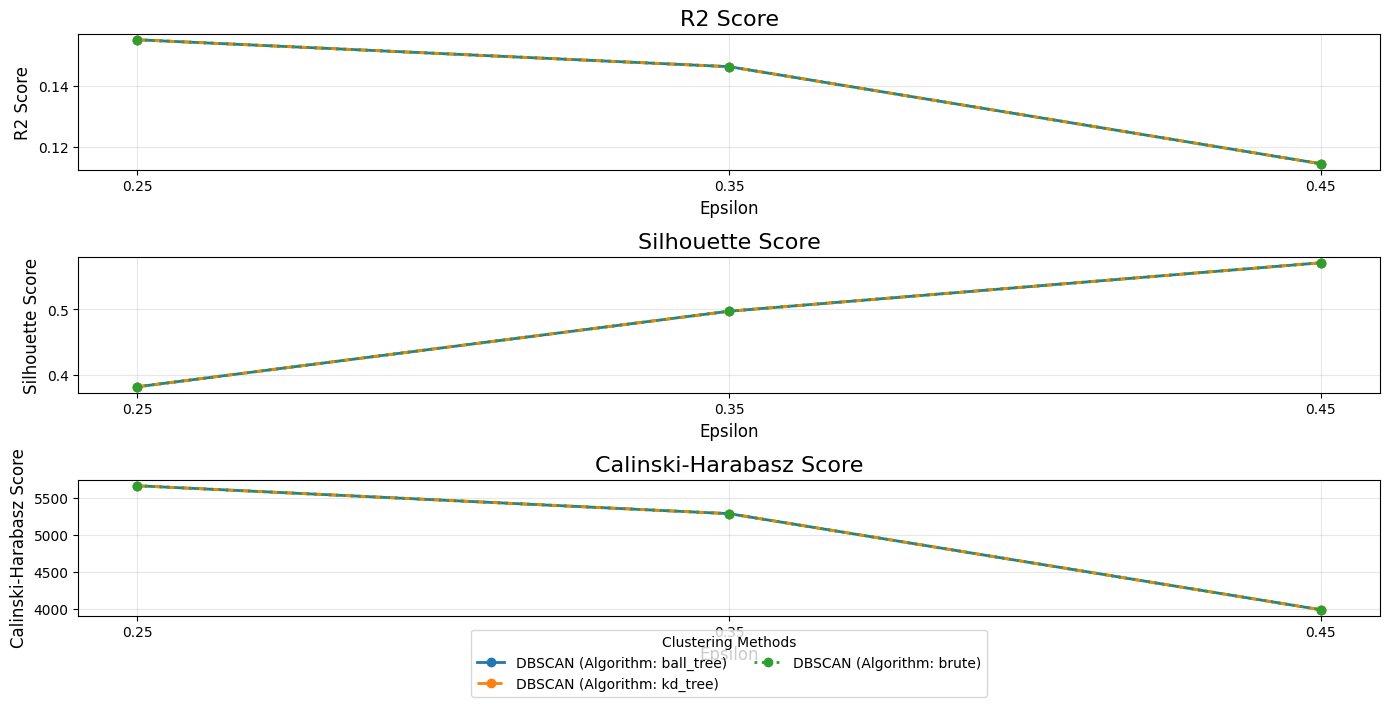

In [9]:
f.plot_evaluation_scores(db_results_df, path+'DBScan_scores')

**Final Model for DBScan**

In [10]:
dbscan = DBSCAN(eps = 0.35)
dblabels = dbscan.fit_predict(scaled_data)

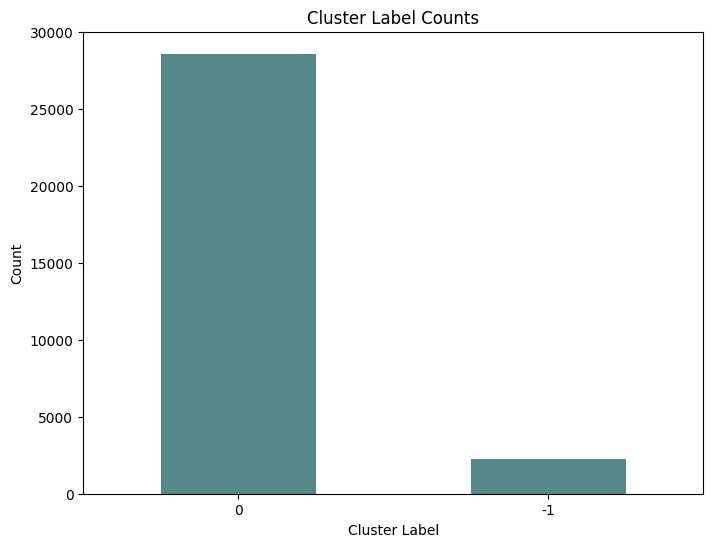

In [11]:
f.plot_counts(dblabels)

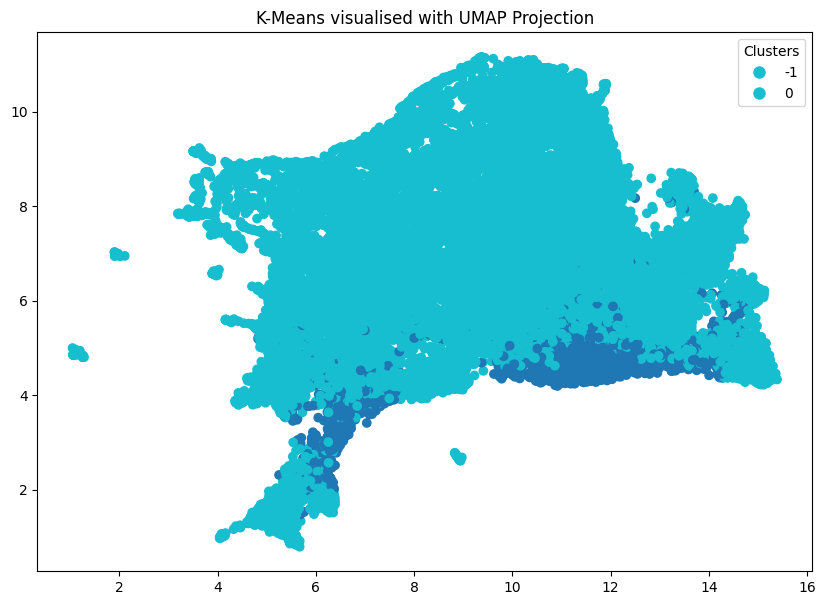

In [12]:
umap_object = umap.UMAP(n_neighbors = 50)
umap_embedding = umap_object.fit_transform(scaled_data)

f.plot_dim_reduction(umap_embedding, targets = dblabels,
                   technique = 'K-Means visualised with UMAP')

### 2.4.3 HDBScan

<a href="#top">Top &#129033;</a>

In [20]:
hdb_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "hdbscan", "min_cluster_size": k, "cluster_selection_method": 'leaf'}
    for k in range(5, 75, 10)  
] + [
    {"model_type": "hdbscan", "min_cluster_size": k, "cluster_selection_method": 'eom'}
    for k in range(5, 75, 10)  
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data, feats=scaled_data.columns.tolist(), **settings)
    hdb_results.append(result)

# Convert results to DataFrame
hdb_results_df = pd.DataFrame(hdb_results)
hdb_results_df

,Model,min_cluster_size,cluster_selection_method,R2,Silhouette,Calinski-Harabasz
0,hdbscan,5,leaf,0.113418,-0.310590,7.113204
1,hdbscan,15,leaf,0.064667,-0.360215,16.858147
2,hdbscan,25,leaf,0.051406,-0.350549,30.341371
3,hdbscan,35,leaf,0.037711,-0.351865,37.740540
4,hdbscan,45,leaf,0.030922,-0.343239,57.870315
5,hdbscan,55,leaf,0.033833,-0.321169,83.061296
6,hdbscan,65,leaf,0.027611,-0.311710,79.604506
7,hdbscan,5,eom,0.120696,-0.314551,9.108254
8,hdbscan,15,eom,0.077404,-0.344438,23.660836
9,hdbscan,25,eom,0.128402,0.010712,1514.725611


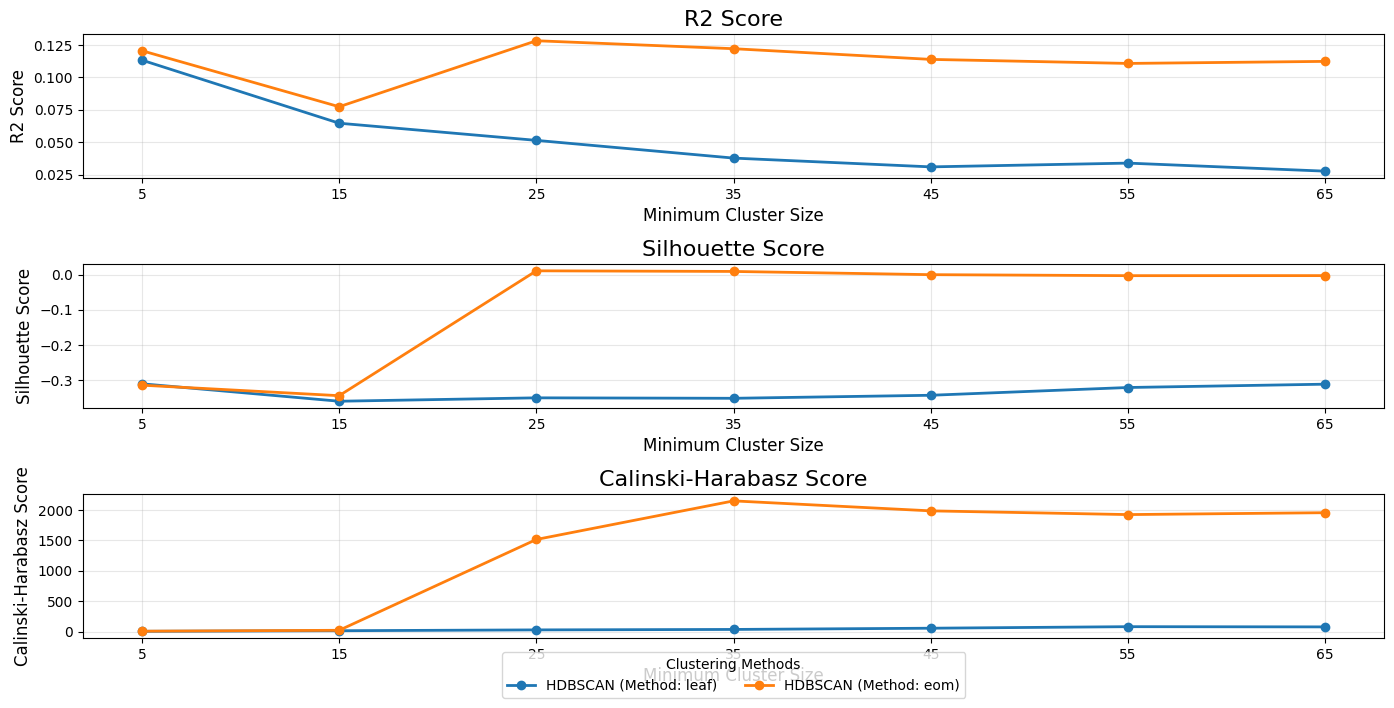

In [21]:
f.plot_evaluation_scores(hdb_results_df, path+'HDBScan_scores')

**Final model for HDBScan**

In [22]:
hdbscan = HDBSCAN(min_cluster_size = 35, 
                  cluster_selection_method = 'eom')

hdblabels = hdbscan.fit_predict(scaled_data)

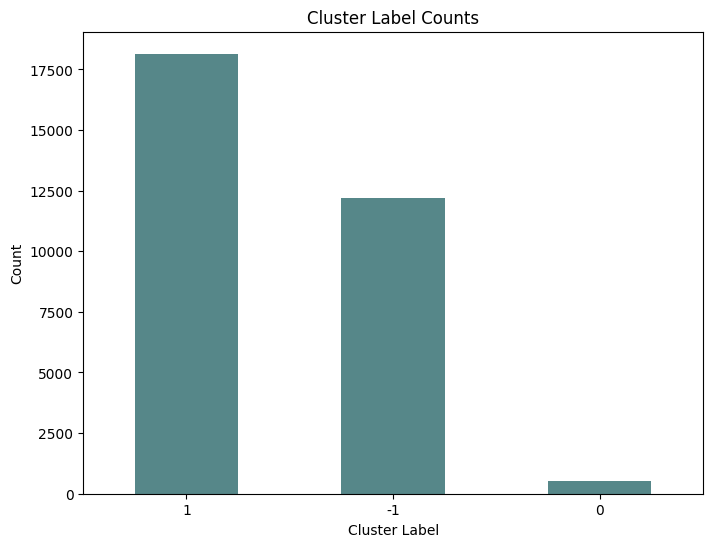

In [23]:
f.plot_counts(hdblabels)

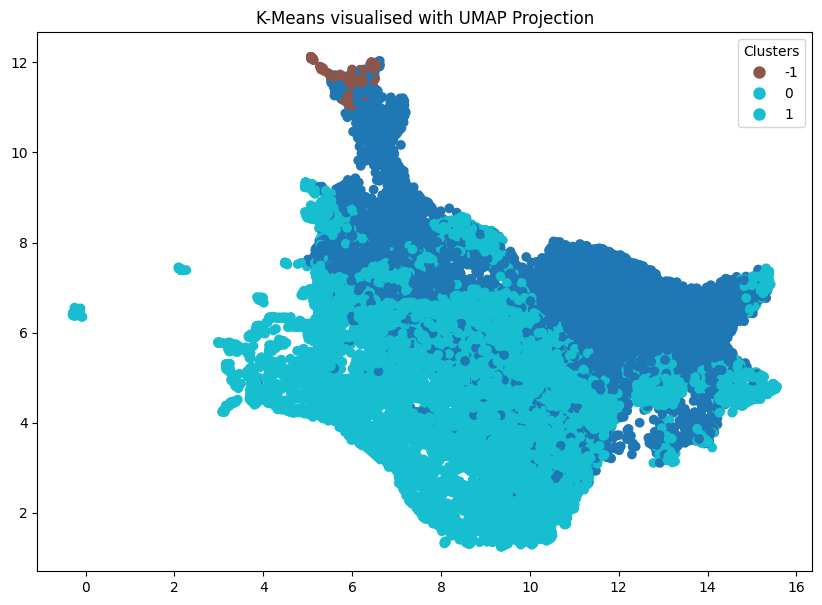

In [24]:
umap_object = umap.UMAP(n_neighbors = 50)
umap_embedding = umap_object.fit_transform(scaled_data)

f.plot_dim_reduction(umap_embedding, targets = hdblabels,
                   technique = 'K-Means visualised with UMAP')

## 2.5 Gaussian Mixture Model (GMM)

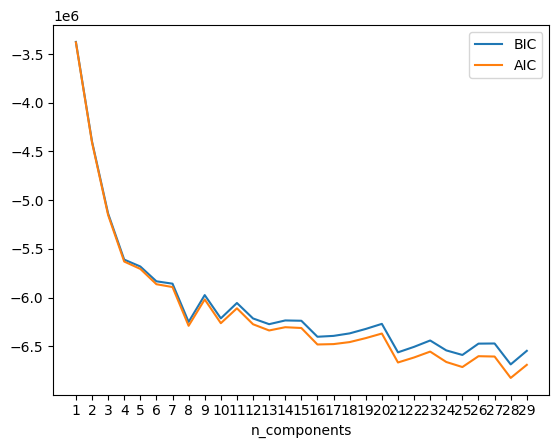

In [9]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, random_state=1).fit(scaled_data)
          for n in n_components]

bic_values = [m.bic(scaled_data) for m in models]
aic_values = [m.aic(scaled_data) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [10]:
gmm = GaussianMixture(random_state = 1)
gmm_labels = gmm.fit_predict(scaled_data)

## 2.6 Self Organising Maps (SOM)

<a href="#top">Top &#129033;</a>

som requires we work with an array and not DF

In [31]:
scaled_data_array = scaled_data.to_numpy()

In [32]:
som = MiniSom(
    15, 
    15, 
    len(scaled_data.columns),
    sigma=0.5,
    neighborhood_function='gaussian',
    learning_rate = 1,
    random_seed=42
    )

In [33]:
np.random.seed(42)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(scaled_data_array, i)
    q_errors.append(som.quantization_error(scaled_data_array))

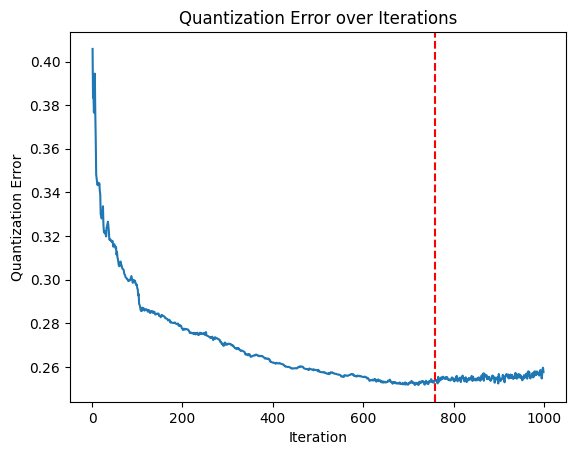

In [34]:
plt.plot(range(1, num_iterations), q_errors)
plt.title('Quantization Error over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Quantization Error')
plt.axvline(x=760, color='red', linestyle='--')
plt.show()

**Retrain SOM**

After analysing the Error Plot, we decided to retrain our previously defined SOM model with **XXX** iterations.

In [35]:
som.train(scaled_data_array, 760)

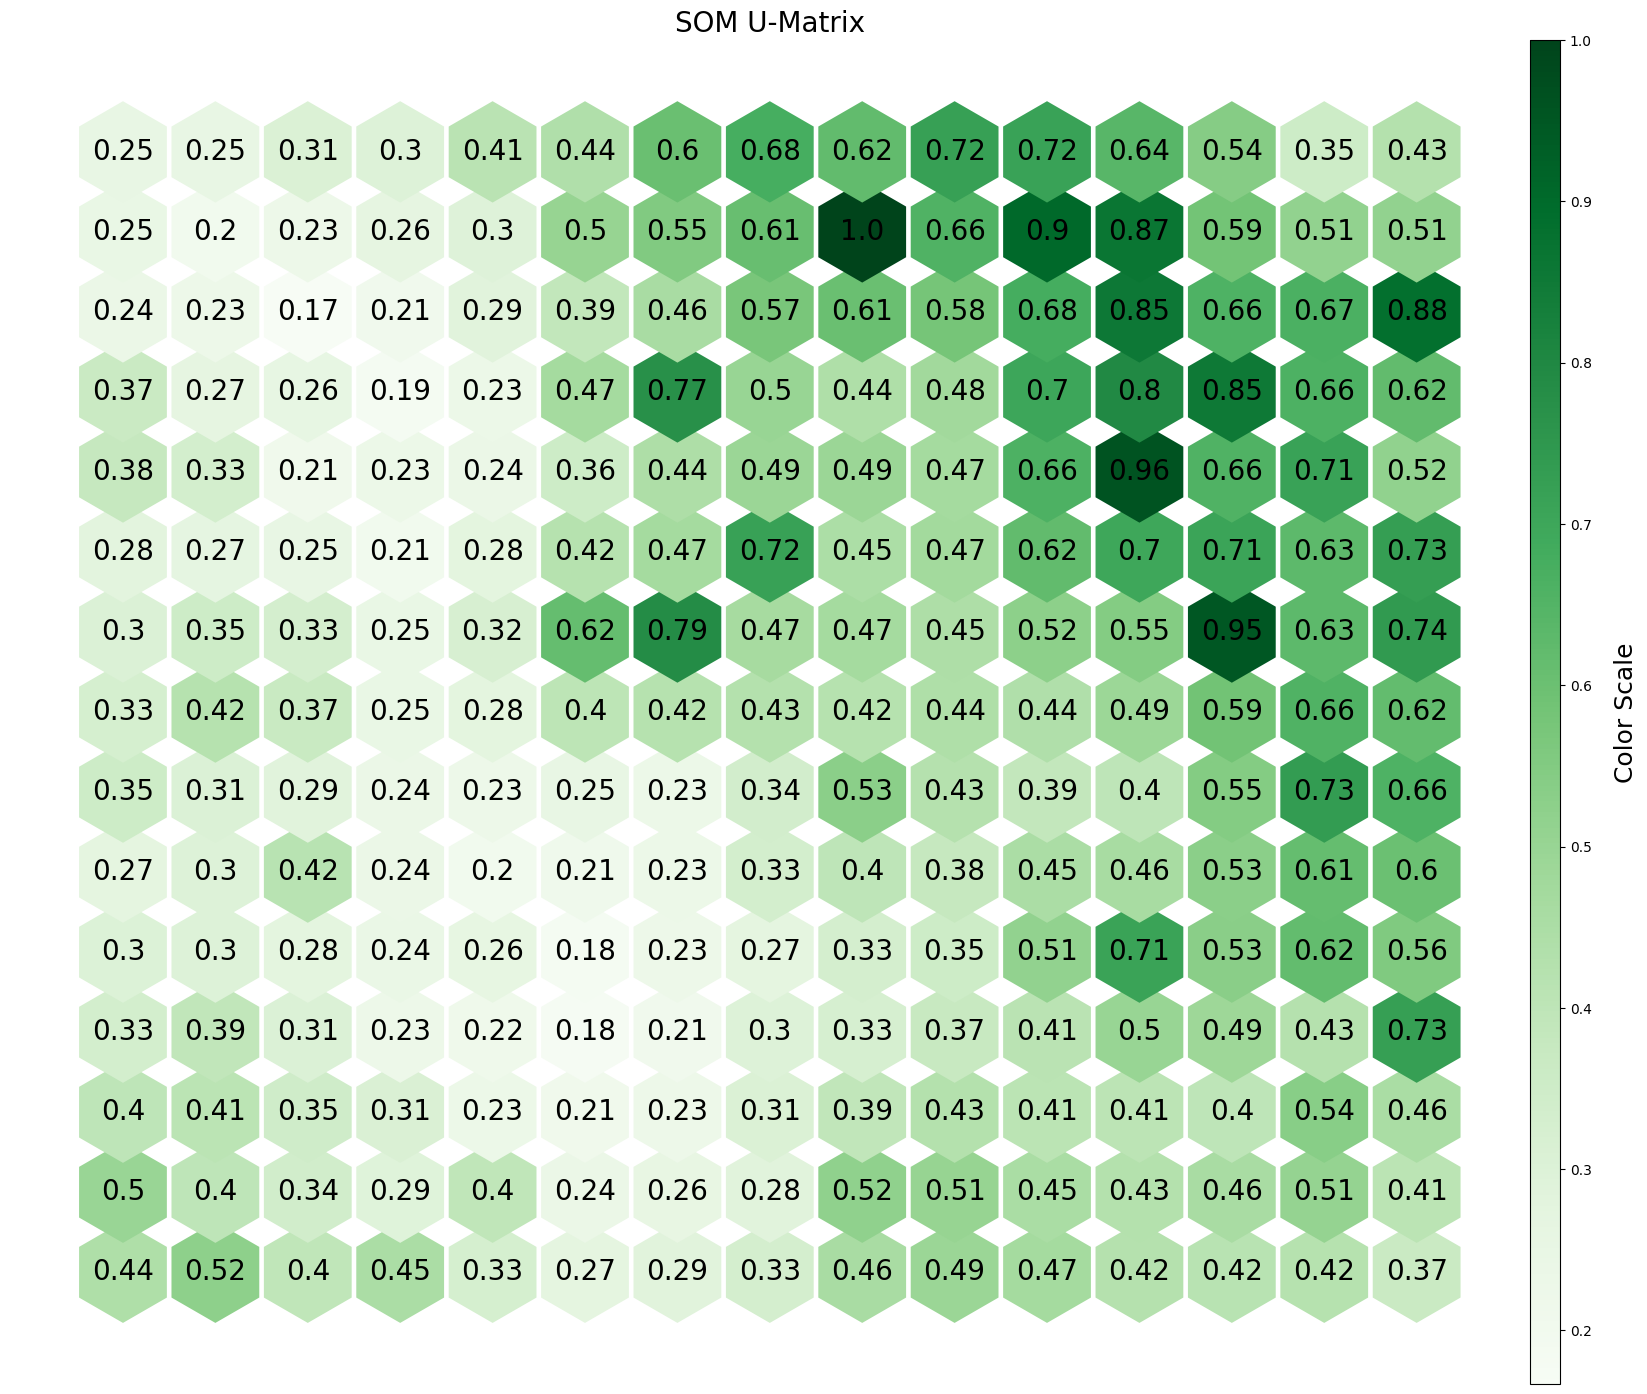

In [41]:
umatrix = som.distance_map(scaling='mean')

fig = f.plot_som_hexagons(som, umatrix, 
                          cmap=cm.Greens, 
                          title="SOM U-Matrix")
plt.show()

# 3. Model Combination

<a href="#top">Top &#129033;</a>

In [42]:
scaled_data_copy = scaled_data.copy()
scaled_data_array_copy = scaled_data_array.copy()

## 3.1 SOM + K-Means

<a href="#top">Top &#129033;</a>

Get Best Matching Units and convert their coordinater to features

In [43]:
som_labels = np.array([som.winner(x) for x in scaled_data_array_copy])

som_features = np.array([som.get_weights()[x[0], x[1]].flatten() for x in som_labels])

Apply K-Means in the SOM features

In [44]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(som_features)
    dispersion.append(kmeans.inertia_)
    

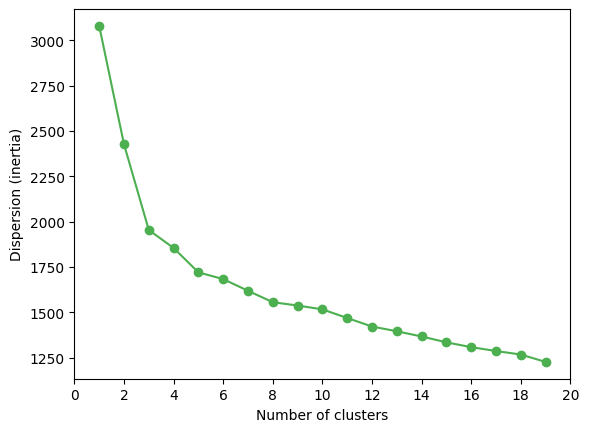

In [45]:
plt.plot(range(1, 20), dispersion, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.xticks(np.arange(0, 21, step=2))  
# plt.vlines(7, 5000, 600000, color='red')

plt.show()

In [46]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, 
                 n_init=15, 
                 random_state=1)

In [47]:
som_kmeans_labels = kmclust.fit_predict(som_features)

In [48]:
feats = scaled_data_copy.columns.to_list()

r2, silhouette, calinski_harabasz = f.cluster_evaluation(scaled_data_copy, 
                                                       feats, som_kmeans_labels)

print(f'R2 for SOM+K-Means: {r2}')
print(f'Silhouette Score for SOM+K-Means: {silhouette}')
print(f'Calinski Harabasz Index for SOM+K-Means: {calinski_harabasz}')

R2 for SOM+K-Means: [0.25998153]
Silhouette Score for SOM+K-Means: [0.16049473]
Calinski Harabasz Index for SOM+K-Means: [5418.54735808]


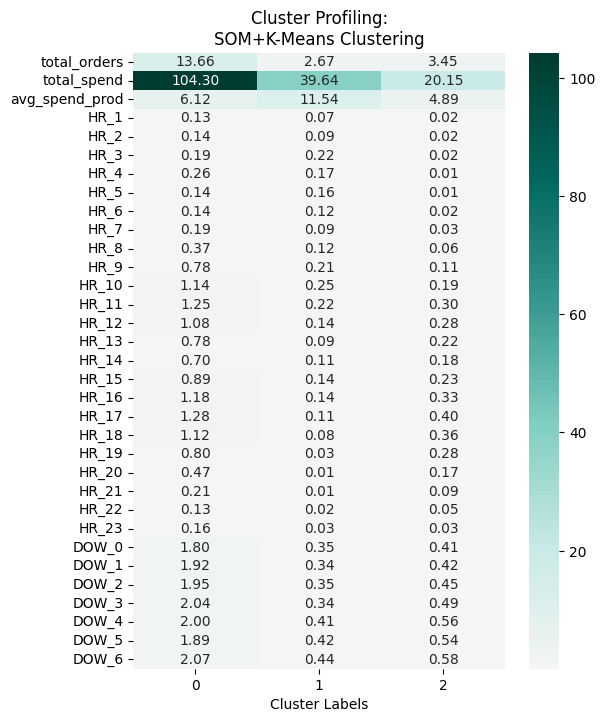

In [49]:
f.plot_cluster_profiling(spending_data, som_kmeans_labels, "SOM+K-Means")

# 4. Model Comparison

<a href="#top">Top &#129033;</a>

Export and Import Result Dataframes

In [ ]:
# hr_results_df.to_csv('./result_dfs/spending_data/hr_results_df.csv')
# results_kmeans_df.to_csv('./result_dfs/spending_data/results_kmeans_df.csv')
# db_results_df.to_csv('./result_dfs/spending_data/db_results_df.csv')
# hdb_results_df.to_csv('./result_dfs/spending_data/hdb_results_df.csv')

In [26]:
hr_results_df = pd.read_csv('./result_dfs/spending_data/hr_results_df.csv')
results_kmeans_df = pd.read_csv('./result_dfs/spending_data/results_kmeans_df.csv')
db_results_df = pd.read_csv('./result_dfs/spending_data/db_results_df.csv')
hdb_results_df = pd.read_csv('./result_dfs/spending_data/hdb_results_df.csv')

Join all Dataframes

In [29]:
dfs = [hr_results_df, results_kmeans_df, db_results_df, hdb_results_df]
results_df = pd.concat(dfs)
results_df.reset_index()
results_df.drop('Unnamed: 0', axis = 1, inplace = True)

Create a new Dataframe with the Model name, Metric Name and corresponding value.

In [30]:
def create_configuration(row):
    if not pd.isna(row.get('n_clusters', None)):
        return f"{row['Model']} (n_clusters={row['n_clusters']})"
    elif not pd.isna(row.get('eps', None)):
        return f"{row['Model']} (eps={row['eps']})"
    elif not pd.isna(row.get('min_cluster_size', None)):
        return f"{row['Model']} (min_cluster_size={row['min_cluster_size']})"
    else:
        return row['Model']

results_df['Configuration'] = results_df.apply(create_configuration, axis=1)

# Reshape the DataFrame into long format
metrics = ['R2', 'Silhouette', 'Calinski-Harabasz']
df_melted = results_df.melt(
    id_vars=['Configuration'],  # Use combined configurations
    value_vars=metrics,
    var_name='Metric',
    value_name='Value'
)

In [31]:
df_melted

,Configuration,Metric,Value
0,hierarchical (n_clusters=2.0),R2,0.128885
1,hierarchical (n_clusters=3.0),R2,0.231338
2,hierarchical (n_clusters=4.0),R2,0.265704
3,hierarchical (n_clusters=5.0),R2,0.286441
4,hierarchical (n_clusters=6.0),R2,0.305402
...,...,...,...
130,hdbscan (min_cluster_size=25.0),Calinski-Harabasz,1514.725611
131,hdbscan (min_cluster_size=35.0),Calinski-Harabasz,2148.075975
132,hdbscan (min_cluster_size=45.0),Calinski-Harabasz,1984.288455
133,hdbscan (min_cluster_size=55.0),Calinski-Harabasz,1923.224727


Plot all models and choose the best

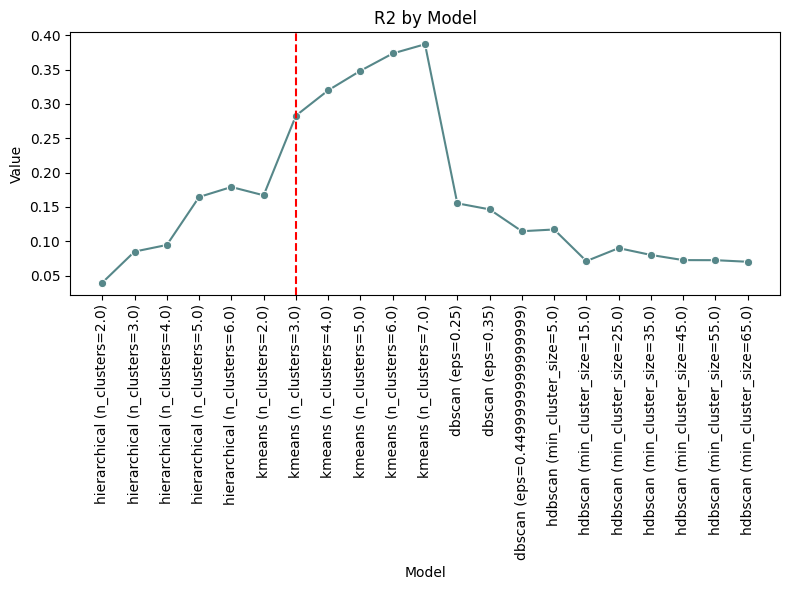

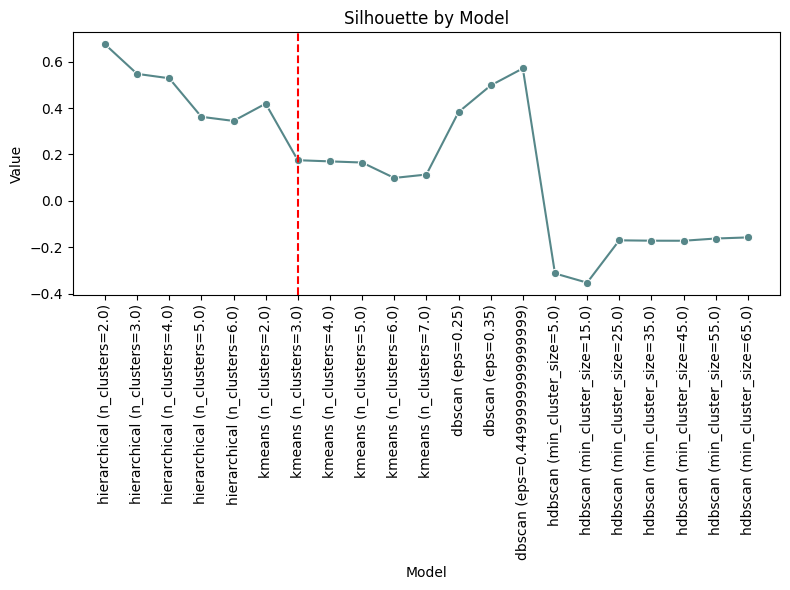

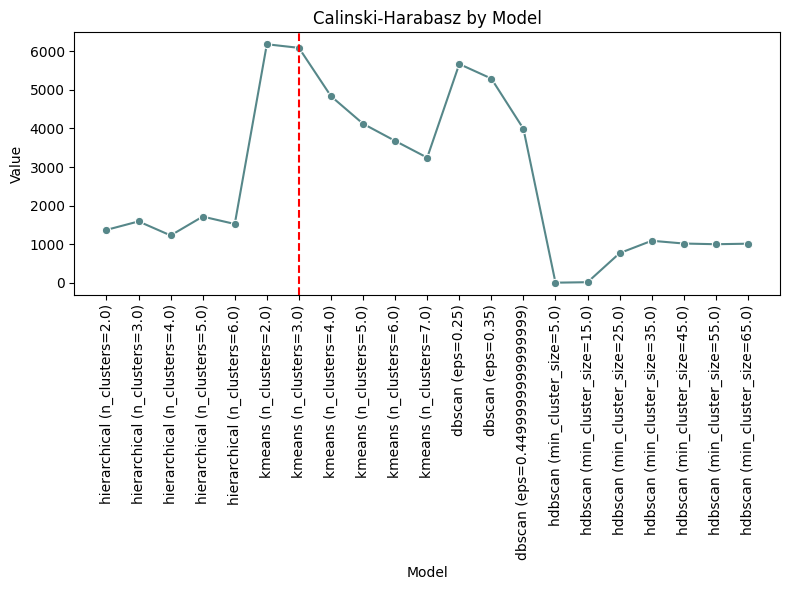

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_comparison(df_melted, metrics, model_for_line, line_color='red', line_style='--', marker='o', figsize=(8, 6)):
    """
    Plot line charts for different metrics and add a vertical line at the specified model.

    Parameters:
    - df_melted: DataFrame containing the melted data.
    - metrics: List of metrics to plot (e.g., ['R2', 'Silhouette', 'Calinski-Harabasz']).
    - model_for_line: The model name where you want to add the vertical line.
    - line_color: Color for the vertical line (default is 'red').
    - line_style: Line style for the vertical line (default is dashed '--').
    - marker: Marker style for the line plot (default is 'o').
    - figsize: Figure size for the plot (default is (8, 6)).
    """
    # Iterate over each metric and create a separate plot
    for metric in metrics:
        # Filter data for the current metric
        data_metric = df_melted[df_melted['Metric'] == metric]

        # Create a new figure for each metric
        plt.figure(figsize=figsize)

        # Plot the data with a specific line color and no legend
        sns.lineplot(
            data=data_metric,
            x='Configuration',
            y='Value',
            marker=marker,
            color='#568789',  
            legend=False,
            ci=None
        )

        # Add the vertical line at the specified model
        plt.axvline(x=model_for_line, color=line_color, linestyle=line_style, label=f'{model_for_line} (Vertical Line)')

        # Remove the grid
        plt.grid(False)

        # Set title and labels
        plt.title(f'{metric} by Model')
        plt.xlabel('Model')
        plt.ylabel('Value')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

        # Adjust the layout for each individual plot
        plt.tight_layout()

        # Show the plot
        plt.show()

# Example of calling the function:
metrics = ['R2', 'Silhouette', 'Calinski-Harabasz']
model_for_line = 'kmeans (n_clusters=3.0)'  
model_comparison(df_melted, metrics, model_for_line)

**Final Solution**

In [35]:
spending_data['spending_data_labels'] = km_labels

In [36]:
spending_data.to_csv('./data/labels/spending_data.csv')